In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
sns.set()

In [2]:
tesla = pd.read_csv('TSLA.csv')
tesla['Date'] = pd.to_datetime(tesla['Date'])
tesla.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-12-20,332.690002,333.100006,325.040009,328.980011,328.980011,5953800
1,2017-12-21,329.589996,333.739990,327.209991,331.660004,331.660004,4385200
2,2017-12-22,329.510010,330.920013,324.820007,325.200012,325.200012,4215800
3,2017-12-26,323.829987,323.940002,316.579987,317.290009,317.290009,4378400
4,2017-12-27,316.000000,317.679993,310.750000,311.640015,311.640015,4712100


In [3]:
def df_shift(df,lag=0, start=1, skip=1, rejected_columns = []):
    df = df.copy()
    if not lag:
        return df
    cols ={}
    for i in range(start,lag+1,skip):
        for x in list(df.columns):
            if x not in rejected_columns:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = (skip - 1)
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=skip
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
    return df

In [4]:
tesla = tesla[['Date','Close']]
tesla.head(1)

,Date,Close
0,2017-12-20,328.980011


In [5]:
df_crosscorrelated = df_shift(tesla, lag = 10, start = 1, skip = 2,rejected_columns=['Date'])
df_crosscorrelated['ma7'] = df_crosscorrelated['Close'].rolling(7).mean()
df_crosscorrelated['ma14'] = df_crosscorrelated['Close'].rolling(14).mean()
df_crosscorrelated['ma25'] = df_crosscorrelated['Close'].rolling(25).mean()
df_crosscorrelated.head(10)

,Date,Close,Close_1,Close_3,Close_5,Close_7,Close_9,ma7,ma14,ma25
0,2017-12-20,328.980011,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-12-21,331.660004,328.980011,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-12-22,325.200012,331.660004,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-12-26,317.290009,325.200012,328.980011,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-12-27,311.640015,317.290009,331.660004,NaN,NaN,NaN,NaN,NaN,NaN
5,2017-12-28,315.359985,311.640015,325.200012,328.980011,NaN,NaN,NaN,NaN,NaN
6,2017-12-29,311.350006,315.359985,317.290009,331.660004,NaN,NaN,320.211435,NaN,NaN
7,2018-01-02,320.529999,311.350006,311.640015,325.200012,328.980011,NaN,319.004290,NaN,NaN
8,2018-01-03,317.250000,320.529999,315.359985,317.290009,331.660004,NaN,316.945718,NaN,NaN
9,2018-01-04,314.619995,317.250000,311.350006,311.640015,325.200012,328.980011,315.434287,NaN,NaN


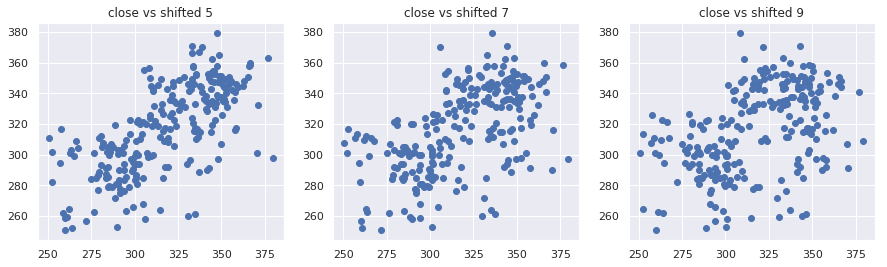

In [6]:
plt.figure(figsize=(15, 4))
plt.subplot(1,3,1)
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_5'])
plt.title('close vs shifted 5')
plt.subplot(1,3,2)
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_7'])
plt.title('close vs shifted 7')
plt.subplot(1,3,3)
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_9'])
plt.title('close vs shifted 9')
plt.show()

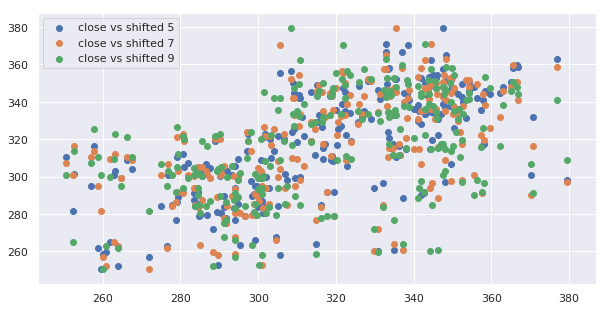

In [7]:
plt.figure(figsize=(10,5))
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_5'],label='close vs shifted 5')
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_7'],label='close vs shifted 7')
plt.scatter(df_crosscorrelated['Close'],df_crosscorrelated['Close_9'],label='close vs shifted 9')
plt.legend()
plt.show()

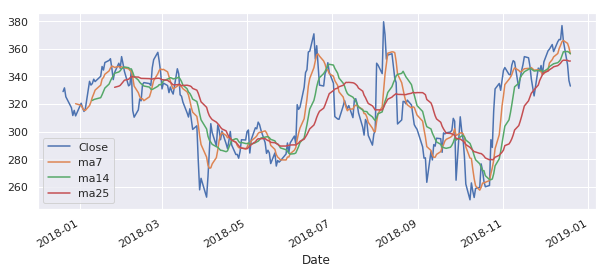

In [8]:
fig, ax = plt.subplots(figsize=(10,4))
df_crosscorrelated.plot(x='Date',y=['Close','ma7','ma14','ma25'],ax=ax)
plt.show()

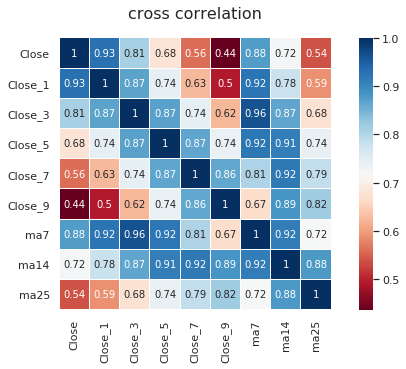

In [9]:
colormap = plt.cm.RdBu
plt.figure(figsize=(10, 5))
ax=plt.subplot(111)
plt.title('cross correlation', y=1.05, size=16)
selected_column = ['Close','Close_1','Close_3','Close_5','Close_7','Close_9','ma7','ma14','ma25']

sns.heatmap(df_crosscorrelated[selected_column].corr(), ax=ax, linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)
plt.show()

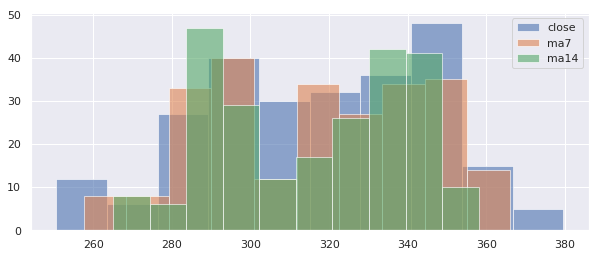

In [10]:
fig, ax = plt.subplots(figsize=(10,4))
df_crosscorrelated['Close'].hist(alpha=0.6,label='close',ax=ax)
df_crosscorrelated['ma7'].hist(alpha=0.6,label='ma7',ax=ax)
df_crosscorrelated['ma14'].hist(alpha=0.6,label='ma14',ax=ax)
plt.legend()
plt.show()

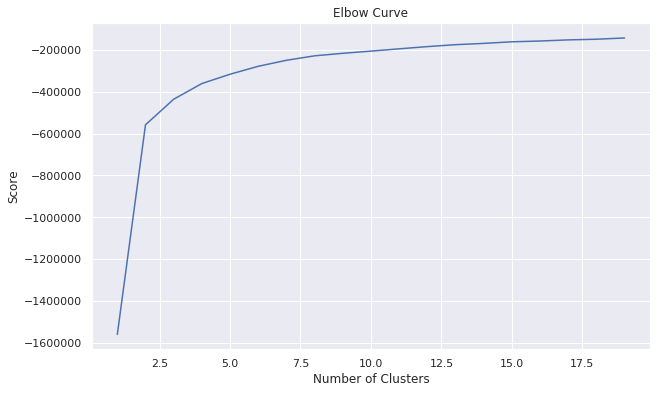

In [11]:
from sklearn.cluster import KMeans

n_cluster = range(1, 20)
data = df_crosscorrelated.iloc[:,1:].dropna().values
kmeans = [KMeans(n_clusters=i).fit(data) for i in n_cluster]
scores = [kmeans[i].score(data) for i in range(len(kmeans))]

fig, ax = plt.subplots(figsize=(10,6))
ax.plot(n_cluster, scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

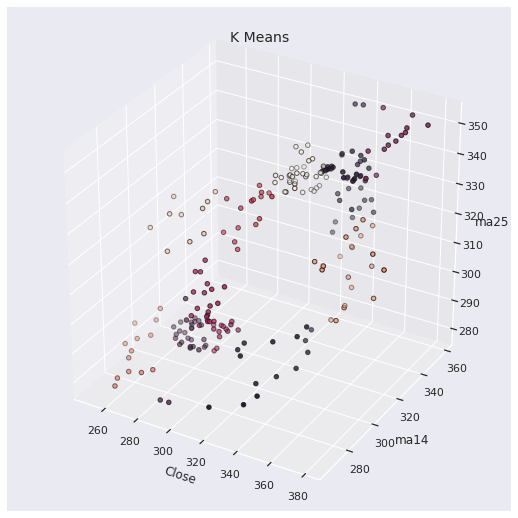

In [12]:
from mpl_toolkits.mplot3d import Axes3D

X = df_crosscorrelated[['Close','ma14','ma25']].dropna()
X = X.reset_index(drop=True)
km = KMeans(n_clusters=10)
km.fit(X)
km.predict(X)
labels = km.labels_

fig = plt.figure(1, figsize=(7,7))
ax = Axes3D(fig)
ax.scatter(X.iloc[:,0], X.iloc[:,1], X.iloc[:,2],
          c=labels.astype(np.float), edgecolor="k")
ax.set_xlabel("Close")
ax.set_ylabel("ma14")
ax.set_zlabel("ma25")
plt.title("K Means", fontsize=14)
plt.show()

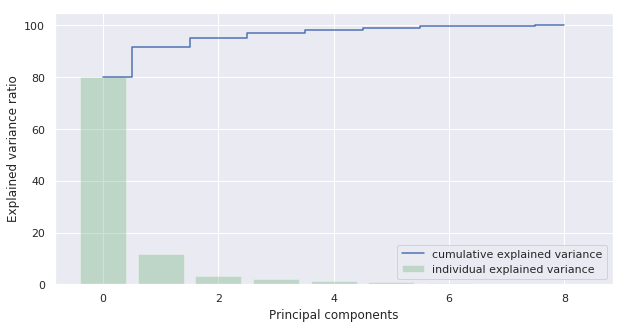

In [13]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

X = df_crosscorrelated.iloc[:,1:].dropna().values
X_std = StandardScaler().fit_transform(X)

mean_vec = np.mean(X_std, axis=0)
cov_mat = np.cov(X_std.T)
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

eig_pairs = [(np.abs(eig_vals[i]),eig_vecs[:,i]) for i in range(len(eig_vals))]

eig_pairs.sort(key = lambda x: x[0], reverse= True)

tot = sum(eig_vals)
var_exp = [(i/tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)

plt.figure(figsize=(10, 5))
plt.bar(range(len(var_exp)), var_exp, alpha=0.3, align='center', label='individual explained variance', color = 'g')
plt.step(range(len(cum_var_exp)), cum_var_exp, where='mid',label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.show();

In [14]:
X = df_crosscorrelated.iloc[:,1:].dropna().values
X_std = StandardScaler().fit_transform(X)
data = pd.DataFrame(X_std)
pca = PCA(n_components=2)
data = pca.fit_transform(data)
scaler = StandardScaler()
np_scaled = scaler.fit_transform(data)

In [15]:
df = df_crosscorrelated.dropna()
kmeans = KMeans(n_clusters=10).fit(np_scaled)
df['cluster'] = kmeans.predict(np_scaled)
df = df.reset_index()
df['principal_feature1'] = np_scaled[:,0]
df['principal_feature2'] = np_scaled[:,1]
df['cluster'].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


5    42
1    33
4    32
2    28
3    24
9    20
6    17
0    16
7     8
8     7
Name: cluster, dtype: int64

In [16]:
def getDistanceByPoint(data, model):
    distance = pd.Series()
    for i in range(0,len(data)):
        Xa = data[i]
        Xb = model.cluster_centers_[model.labels_[i]-1]
        distance.set_value(i, np.linalg.norm(Xa-Xb))
    return distance

outliers_fraction = 0.1
distance = getDistanceByPoint(np_scaled, kmeans)
number_of_outliers = int(outliers_fraction*len(distance))
threshold = distance.nlargest(number_of_outliers).min()
df['anomaly1'] = (distance >= threshold).astype(int)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  


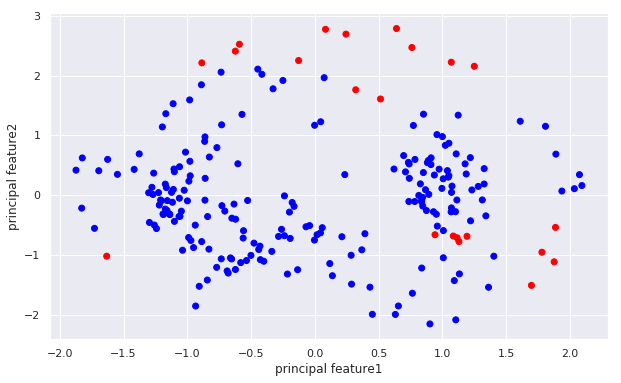

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
colors = {0:'blue', 1:'red'}
ax.scatter(df['principal_feature1'], df['principal_feature2'], c=df["anomaly1"].apply(lambda x: colors[x]))
plt.xlabel('principal feature1')
plt.ylabel('principal feature2')
plt.show()

In [18]:
df.anomaly1.value_counts()

0    205
1     22
Name: anomaly1, dtype: int64

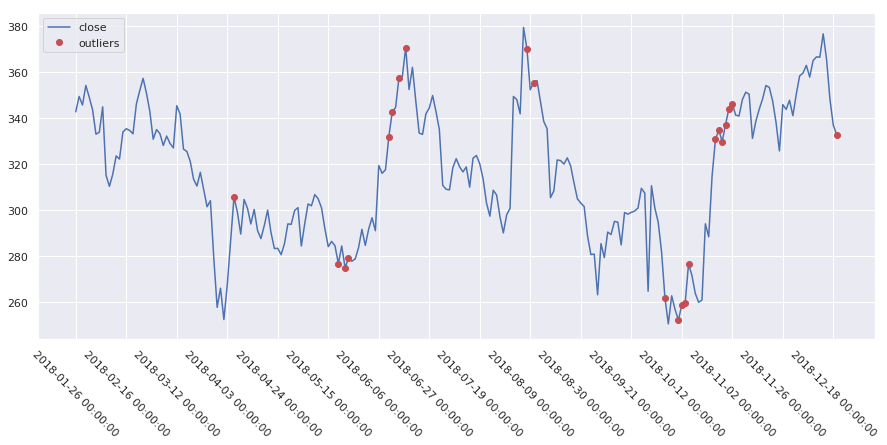

In [51]:
plt.figure(figsize=(15, 6))
plt.plot(df['Close'], label='close',c='b')
plt.plot(df['Close'], 'o', label='outliers',markevery=df.loc[df['anomaly1'] == 1].index.tolist(),c='r')
plt.xticks(np.arange(df.shape[0])[::15],df['Date'][::15],rotation='-45')
plt.legend()
plt.show()

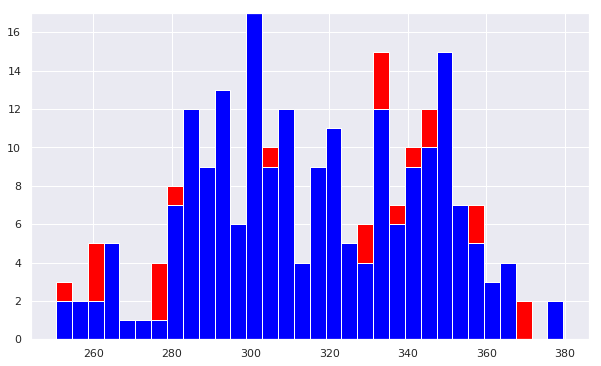

In [42]:
a = df.loc[df['anomaly1'] == 0, 'Close']
b = df.loc[df['anomaly1'] == 1, 'Close']

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show()

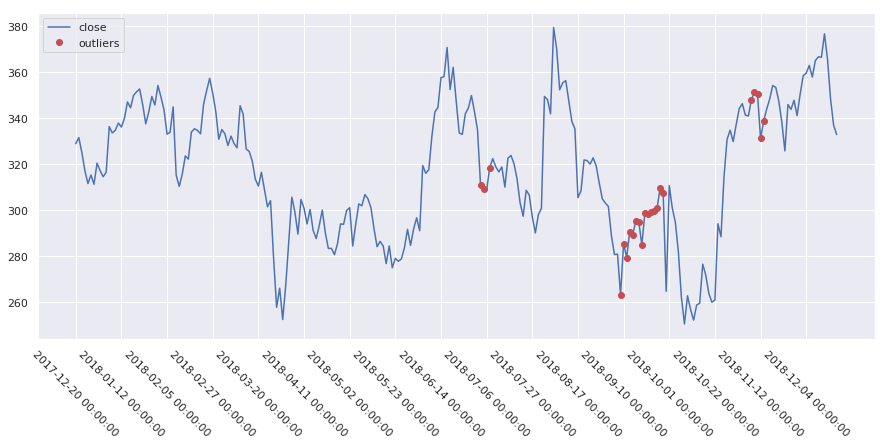

In [61]:
from sklearn.ensemble import IsolationForest

X = df_crosscorrelated.iloc[:,1:].dropna().values
np_scaled = StandardScaler().fit_transform(X)

model = IsolationForest(contamination=outliers_fraction)
model.fit(np_scaled)
outliers = model.predict(np_scaled)

plt.figure(figsize=(15, 6))
plt.plot(df_crosscorrelated['Close'], label='close',c='b')
plt.plot(df_crosscorrelated['Close'], 'o', label='outliers',markevery=np.where(outliers==-1)[0].tolist(),c='r')
plt.xticks(np.arange(df_crosscorrelated.shape[0])[::15],df_crosscorrelated['Date'][::15],rotation='-45')
plt.legend()
plt.show()

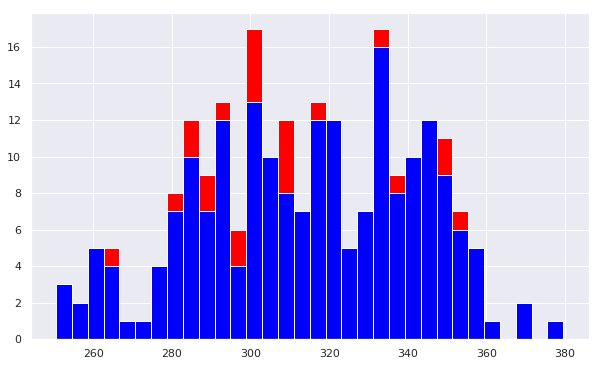

In [62]:
close = df_crosscorrelated['Close'].values
a = close[np.where(outliers==1)[0]]
b = close[np.where(outliers==-1)[0]]

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show()

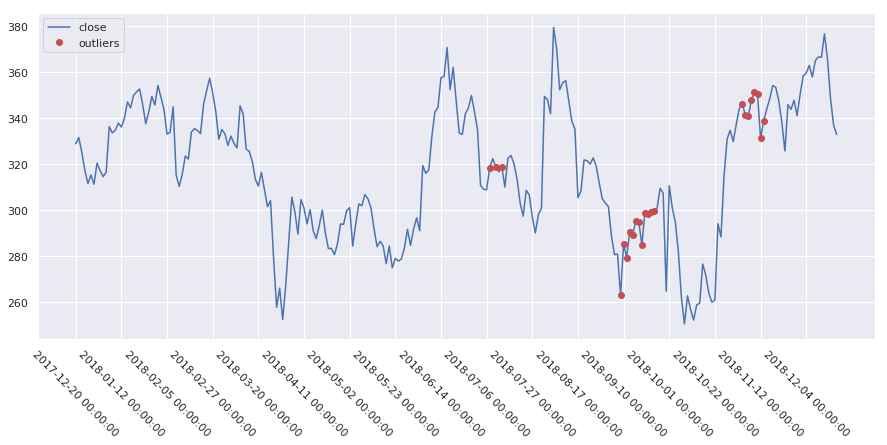

In [65]:
from sklearn.svm import OneClassSVM

X = df_crosscorrelated.iloc[:,1:].dropna().values
np_scaled = StandardScaler().fit_transform(X)
model = OneClassSVM(nu=outliers_fraction, kernel="rbf", gamma=0.01)
model.fit(np_scaled)
outliers = model.predict(np_scaled)

plt.figure(figsize=(15, 6))
plt.plot(df_crosscorrelated['Close'], label='close',c='b')
plt.plot(df_crosscorrelated['Close'], 'o', label='outliers',markevery=np.where(outliers==-1)[0].tolist(),c='r')
plt.xticks(np.arange(df_crosscorrelated.shape[0])[::15],df_crosscorrelated['Date'][::15],rotation='-45')
plt.legend()
plt.show()

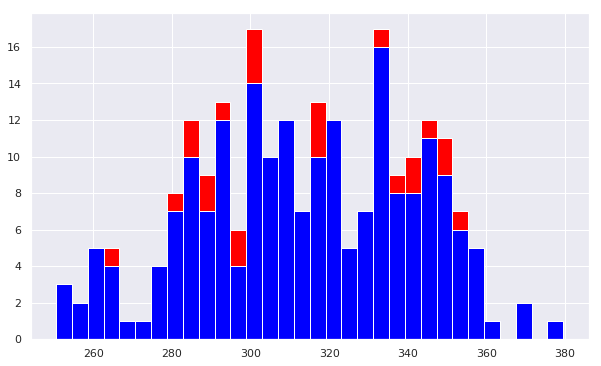

In [66]:
close = df_crosscorrelated['Close'].values
a = close[np.where(outliers==1)[0]]
b = close[np.where(outliers==-1)[0]]

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show()

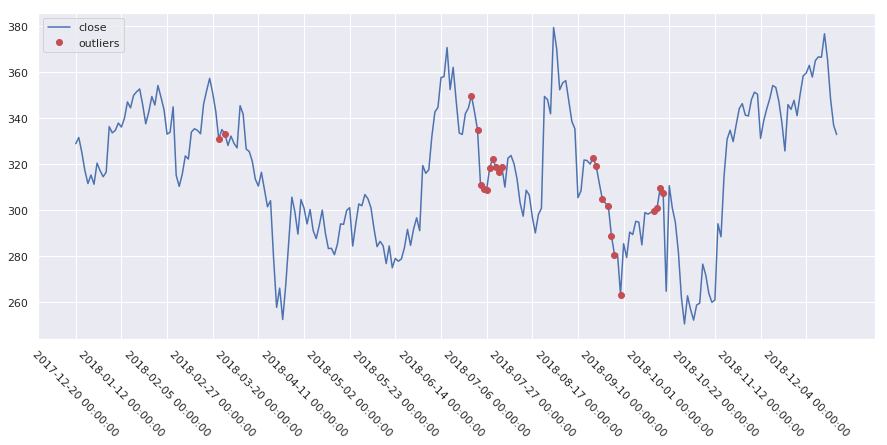

In [70]:
from sklearn.covariance import EllipticEnvelope

envelope = EllipticEnvelope(contamination = outliers_fraction)
X = df_crosscorrelated.iloc[:,1:].dropna().values
np_scaled = StandardScaler().fit_transform(X)
envelope.fit(np_scaled)
outliers = envelope.predict(np_scaled)

plt.figure(figsize=(15, 6))
plt.plot(df_crosscorrelated['Close'], label='close',c='b')
plt.plot(df_crosscorrelated['Close'], 'o', label='outliers',markevery=np.where(outliers==-1)[0].tolist(),c='r')
plt.xticks(np.arange(df_crosscorrelated.shape[0])[::15],df_crosscorrelated['Date'][::15],rotation='-45')
plt.legend()
plt.show()

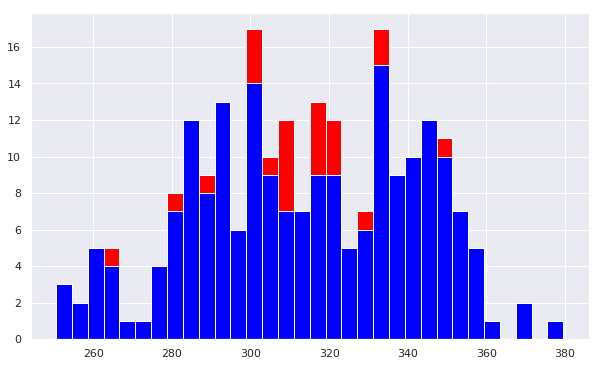

In [71]:
close = df_crosscorrelated['Close'].values
a = close[np.where(outliers==1)[0]]
b = close[np.where(outliers==-1)[0]]

fig, axs = plt.subplots(figsize=(10,6))
axs.hist([a,b], bins=32, stacked=True, color=['blue', 'red'])
plt.show()